## Описание проекта
Интернет-магазин «В один клик» заметил снижение активности покупателей. Привлекать новых клиентов становится сложнее, поэтому компания решила сосредоточиться на удержании постоянных клиентов с помощью персонализированных предложений. Для этого необходимо разработать модель, предсказывающую вероятность снижения активности клиентов, и предложить рекомендации для повышения их вовлеченности.
Основные этапы проекта: 
- Загрузка и предобработка данных
- Исследовательский анализ каждого признака
- Корреляционный анализ (выявления зависимости между признаками)
- Обучение модели для предсказания активности пользователей
- Анализ важности признаков
- Выявление рекомендаций 

In [1]:
!pip install shap -q
!pip install --upgrade scikit-learn -q

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [3]:
df_market_filed = pd.read_csv('/datasets/market_file.csv')
df_market_filed.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
df_market_time = pd.read_csv('/datasets/market_time.csv')
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Мини-вывод по загруженным датасетам
Были загружены четыре датасета, содержащие информацию о маркетинговой активности, выручке, времени, проведённом на сервисе, и прибыли клиентов.

1. df_market_filed – данные о покупательской активности и характеристиках клиентов, включая категорию товаров, количество неоплаченных продуктов и средний просмотр страниц за визит.
0. df_market_money – информация о выручке клиентов за разные периоды (текущий, предыдущий и препредыдущий месяцы).
0. df_market_time – данные о времени, проведённом клиентами на платформе в разные месяцы.
0. df_money – информация о прибыли клиентов, загруженная с отличающимися параметрами (sep=';', decimal=',').

**Следующим шагом потребуется провести предварительную обработку данных: проверить корректность типов, наличие пропусков и возможных ошибок в данных.**

## Предобработка данных

In [7]:
# Функция для проверки данных
def preprocess(df):
    print('Количество пропусков:')
    print(df.isna().sum())
    print('\nКоличество явных дубликатов: ', df.duplicated().sum())
    
    # Создание копии набора данных 
    df_copy = df.copy()

    # Приведение к нижнему регистру и удаление пробелов для проверки неявных дубликатов
    for col in df_copy.select_dtypes(include=['object', 'category']).columns:
        df_copy[col] = df_copy[col].str.lower().str.replace(' ', '', regex=False)

    print(f'Количестов неявных дубликатов: {df_copy.duplicated().sum()}\n')

    # Удаляем копию для экономии памяти
    del df_copy

    # Проверка уникальных значений для котегориальных значений
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f'Столбец: {col} \nзначения столбца: {df[col].unique()}\n')

### Работа с набором данных df_market_filed

In [8]:
df_market_filed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Типы данных столбцов корректны

In [9]:
preprocess(df_market_filed)

Количество пропусков:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0

Столбец: Покупательская активность 
значения столбца: ['Снизилась' 'Прежний уровень']

Столбец: Тип сервиса 
значения столбца: ['премиум' 'стандартт' 'стандарт']

Столбец: Разрешить сообщать 
значения столбца: ['да' 'нет']

Столбец: Популярная_категория 
значения столбца: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здор

Пропусков не обнаружено 

Явных дубликатов не обнаружено 

Выявлен один неявный дубликат в столбце Тип сервиса 

In [10]:
# Замена дубликата ('стандартт') в столбце Тип сервиса
df_market_filed['Тип сервиса'] = df_market_filed['Тип сервиса'].replace('стандартт', 'стандарт')
df_market_filed['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

### Работа с набором данных df_market_money

In [11]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Типы данных столбцов корректны

In [12]:
preprocess(df_market_money)

Количество пропусков:
id         0
Период     0
Выручка    0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0

Столбец: Период 
значения столбца: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



Пропусков не обнаружено 

Явных и неявных дубликатов не обнаружено 


### Работа с набором данных df_market_time

In [13]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Типы данных столбцов корректны

In [14]:
preprocess(df_market_time)

Количество пропусков:
id        0
Период    0
минут     0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0

Столбец: Период 
значения столбца: ['текущий_месяц' 'предыдцщий_месяц']



Пропусков не обнаружено 

Явных дубликатов не обнаружено 

Выявлена ошибка в написании значения столбца Период 'предыдЦЩий_месяц'

In [15]:
# Замена дубликата ('предыдцщий_месяц') в столбце Период
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

### Работа с набором данных df_market_time

In [16]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Типы данных столбцов корректны

In [17]:
preprocess(df_money)

Количество пропусков:
id         0
Прибыль    0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0



Пропусков не обнаружено 

Явных и неявных дубликатов не обнаружено 

### Мини-вывод по предобработке данных
В ходе предобработки данных проведены следующие этапы:

1. Проверка и очистка данных
    - Отсутствуют пропуски во всех загруженных наборах данных.
    - Явных дубликатов не обнаружено.
    - Выполнена проверка на неявные дубликаты в текстовых полях.
0. Исправление ошибок в данных
    - В столбце "Тип сервиса" исправлена опечатка: "стандартт" заменён на "стандарт".
    - В наборе df_market_time исправлено некорректное название периода "предыдцщий_месяц" → "предыдущий_месяц".
0. Проверка типов данных
    - Типы данных корректны во всех датасетах, изменений не потребовалось.

**Итог: Данные очищены от ошибок и готовы к дальнейшему анализу.**

## Исследовательский анализ данных

In [18]:
def plot_histogram(df, col, target=None):
    """
    Строит гистограмму распределения значений признака.
    
    Parameters:
    df (pandas.DataFrame): Датасет.
    col (str): Название столбца.
    target (str, optional): Название целевого признака для раскраски.
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.ylabel('Количество', fontsize=14)
    plt.show()
    

def plot_histogram_with_boxplot(df, col, target=None):
    """
    Строит гистограмму и boxplot для числового признака.
    
    Parameters:
    df (pandas.DataFrame): Датасет.
    col (str): Название числового столбца.
    target (str, optional): Название целевого признака для раскраски.
    """
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Гистограмма
    axes[0].set_title(f'Распределение признака {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    
    # Boxplot
    axes[1].set_title(f'Ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    
    plt.show()


def plot_pivot_pie_chart(df, col):
    """
    Строит круговую диаграмму частоты значений признака.
    
    Parameters:
    df (pandas.DataFrame): Датасет.
    col (str): Название категориального столбца.
    """
    value_counts = df[col].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()

### Работа с набором данных df_market_filed

In [19]:
df_market_filed.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


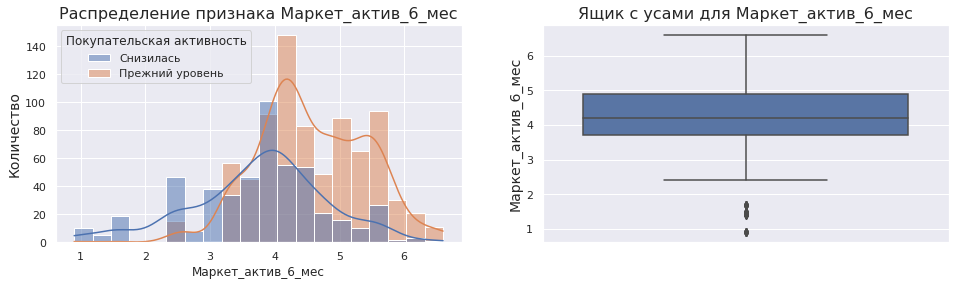

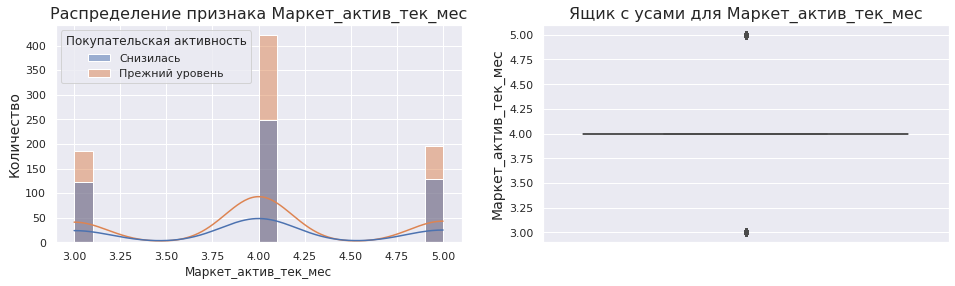

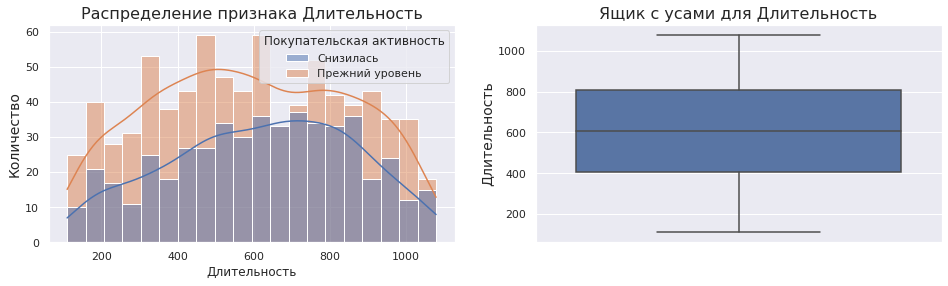

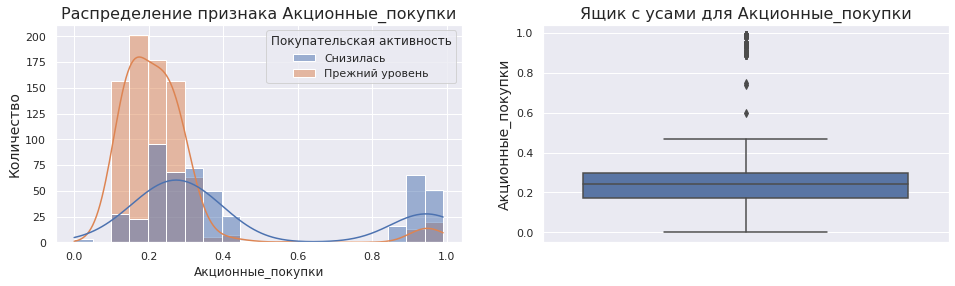

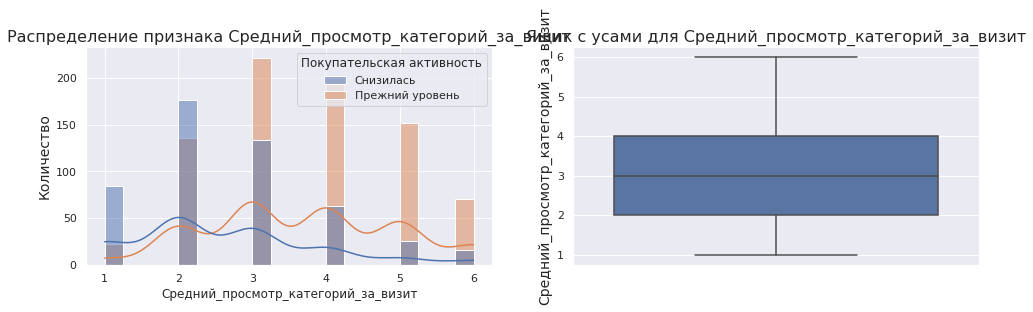

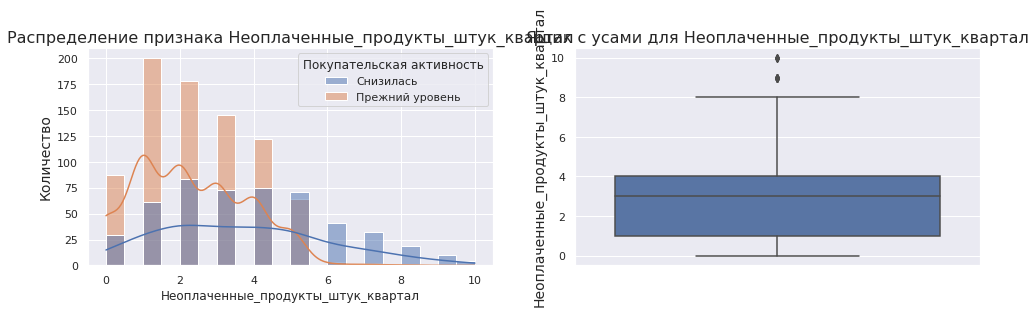

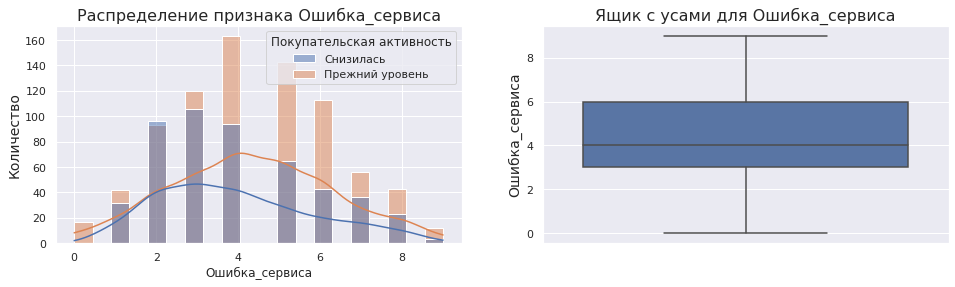

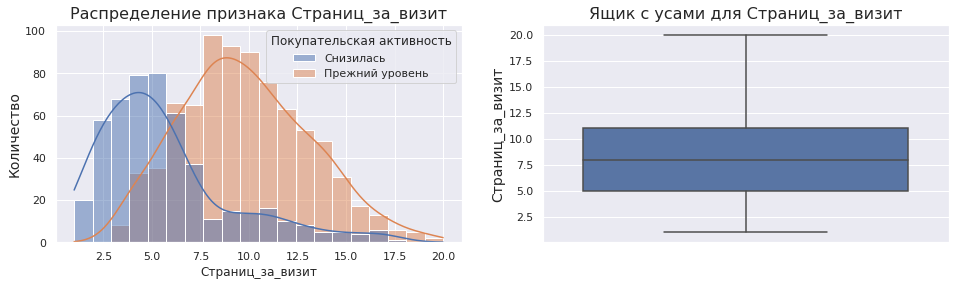

In [20]:
for col in df_market_filed.columns:
    if col == 'id':
        continue
    if df_market_filed[col].dtype in ['int64', 'float64']:  # Для числовых данных строим гистограмму
        plot_histogram_with_boxplot(df_market_filed, col, target='Покупательская активность')

In [21]:
"""
Преобразуем столбцы:
Маркет_актив_тек_мес
Средний_просмотр_категорий_за_визит
Неоплаченные_продукты_штук_квартал
Ошибка_сервиса
"""

columns_retype = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 
                  'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса']

for column in columns_retype:
    df_market_filed[column] = df_market_filed[column].astype('category')
    
for types in columns_retype:
    print(f'Столбец - {types}\nТип данных: {df_market_filed[column].dtype}')

Столбец - Маркет_актив_тек_мес
Тип данных: category
Столбец - Средний_просмотр_категорий_за_визит
Тип данных: category
Столбец - Неоплаченные_продукты_штук_квартал
Тип данных: category
Столбец - Ошибка_сервиса
Тип данных: category


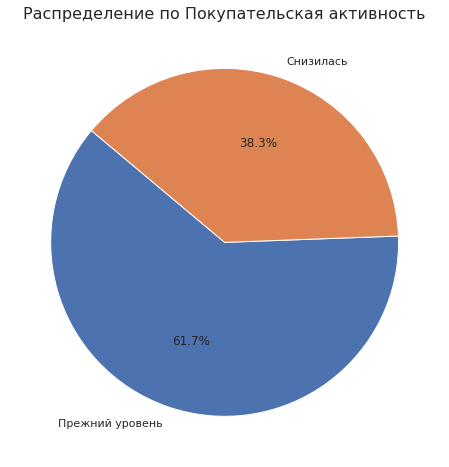

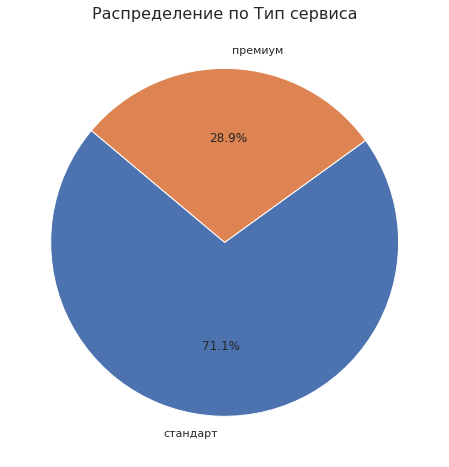

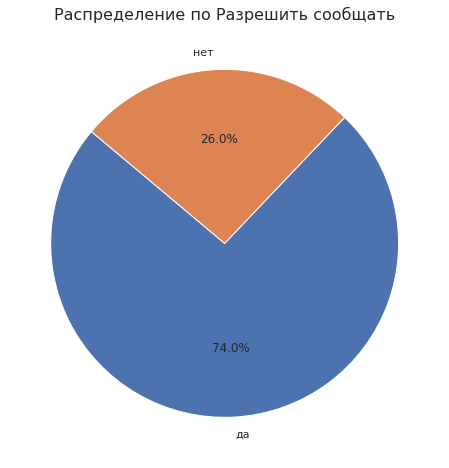

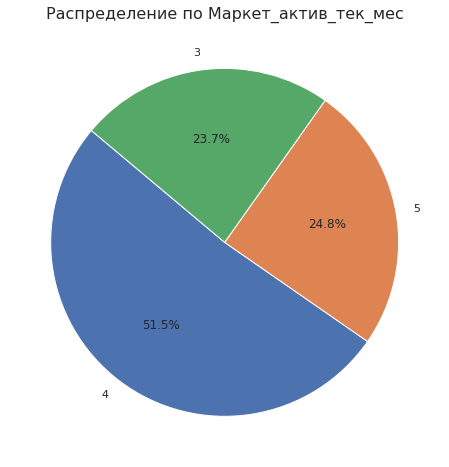

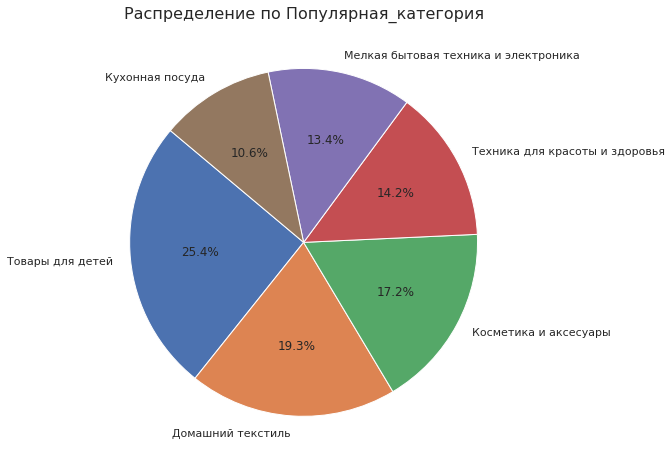

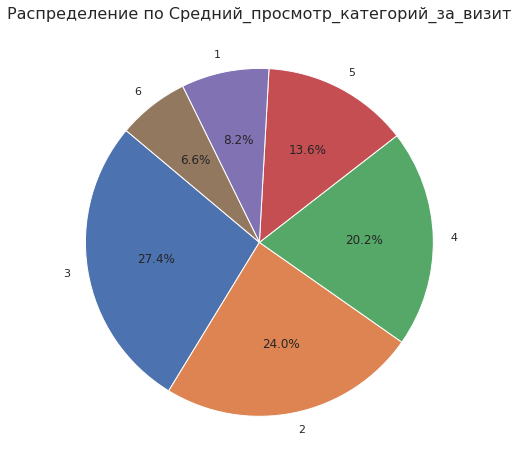

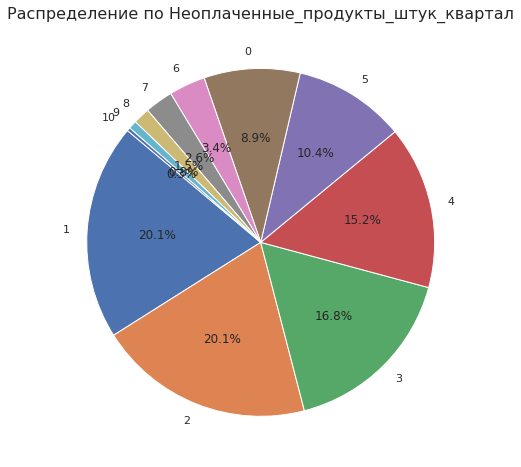

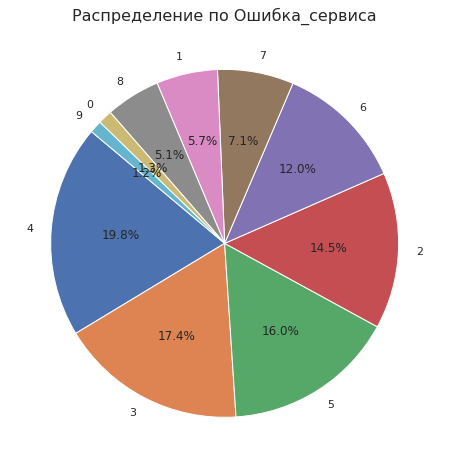

In [22]:
for col in df_market_filed.columns:
    if df_market_filed[col].dtype in ['object', 'category']:  # Для категориальных данных строим круговую диаграмму
        plot_pivot_pie_chart(df_market_filed, col)

Описание столбцов
- **Маркет_актив_6_мес** – Уровень активности в маркетплейсе за 6 месяцев, среднее 4.25, есть выбросы в минимальных значениях.
- **Маркет_актив_тек_мес** – Активность за текущий месяц, преобразован в котегориальный столбец, данные стабильны.
- **Длительность** – Время взаимодействия с сервисом, среднее 601, есть большой размах (110–1079), выбросов нет.
- **Акционные_покупки** – Доля покупок по акциям, варьируется от 0 до 0.99, без явных выбросов.
- **Средний_просмотр_категорий_за_визит** – В среднем 3.27 категории, разброс от 1 до 6, распределение выглядит нормальным, преобразован в котегориальный столбец.
- **Неоплаченные_продукты_штук_квартал** – В среднем 2.84 товара, выбросы в максимальном значении (9 и 10), преобразован в котегорильный столбец.
- **Ошибка_сервиса** – Среднее 4.18, диапазон от 0 до 9, нормально распределены, преобразован в котегориальный столбец.
- **Страниц_за_визит** – разброс от 1 до 20, слегка скошенное влево нормальное распределение, можно было бы преобразовать в котегориальный столбец, но не выводить диаграмму (слишком много значений, диаграмма будет нечитаема).

### Работа с набором данных df_market_money

In [23]:
df_market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Выявлено слишком большое значение в столбце Выручка

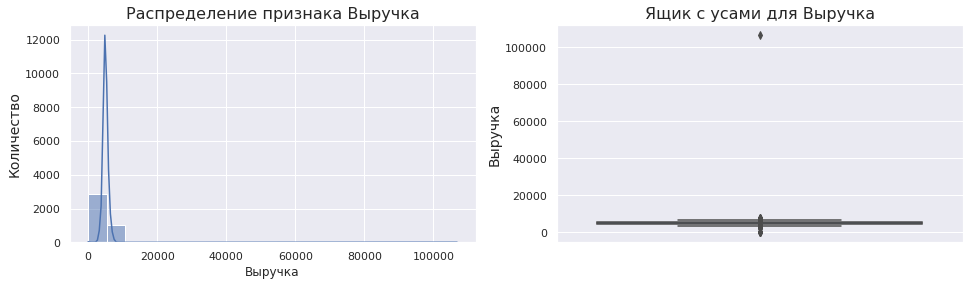

In [24]:
plot_histogram_with_boxplot(df_market_money, 'Выручка')

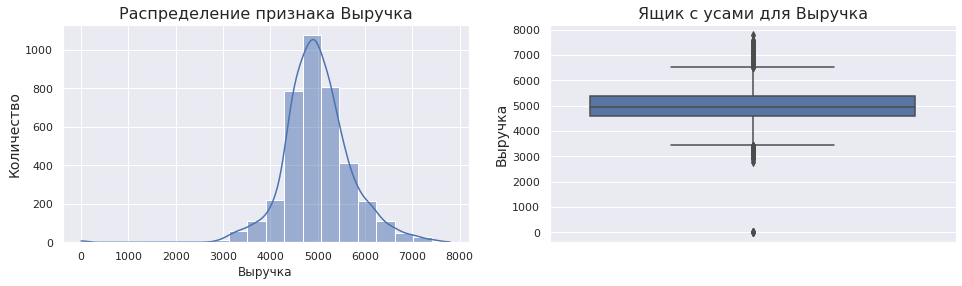

In [25]:
# Удаление выброса
df_market_money = df_market_money[df_market_money['Выручка'] < 10000]

plot_histogram_with_boxplot(df_market_money, 'Выручка')

Нас не интересуют клиенты которые ничего не покупали по этому отберём только тех, которые хотя бы что то покупали

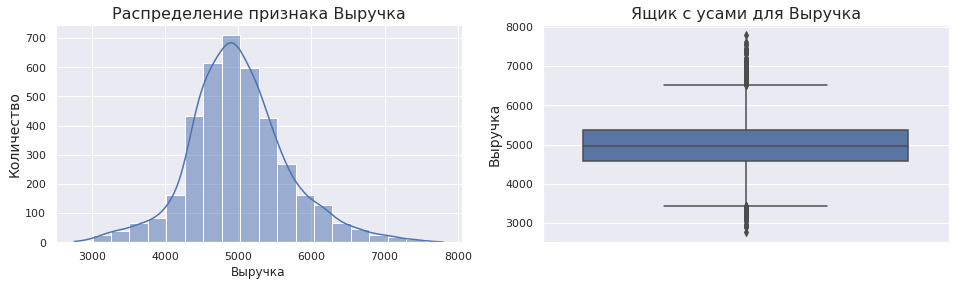

In [26]:
# Удаление клиентов в '0' выручки
df_market_money = df_market_money[df_market_money['Выручка'] > 0]

plot_histogram_with_boxplot(df_market_money, 'Выручка')

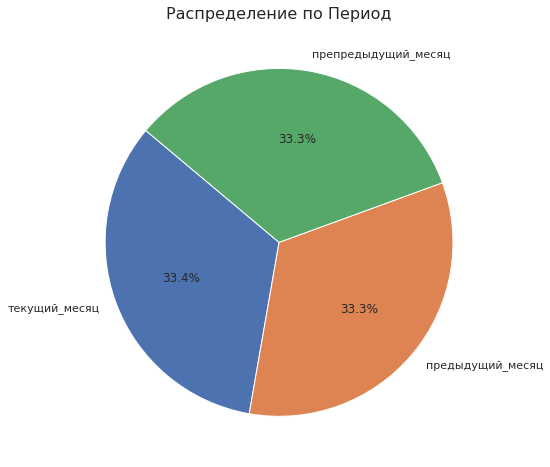

In [27]:
 plot_pivot_pie_chart(df_market_money, 'Период')

Описание столбцов:
- В столбце "Период" все значения содержатся в одинаковом количестве  
- Столбец "Выручка" был обрезан по значениям 0 < 'Выручка' < 10000, чтобы избавиться от критических выбросов и отбросить клиентов от которых нет прибыли

### Работа с набором данных df_market_time

In [28]:
df_market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


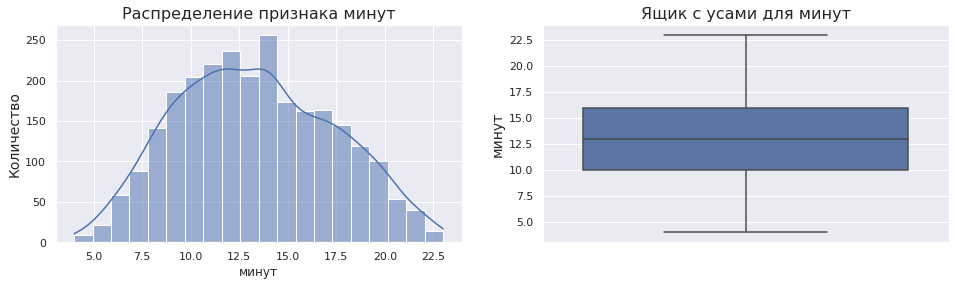

In [29]:
plot_histogram_with_boxplot(df_market_time, 'минут')

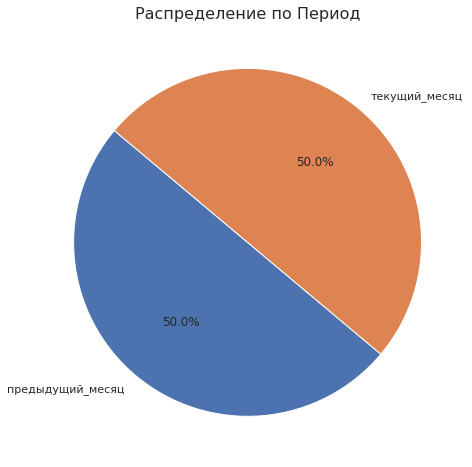

In [30]:
 plot_pivot_pie_chart(df_market_time, 'Период')

Описание столбцов:
- Столбец "Минут" распределён нормально
- Количество значений в столбеце "Период" одинаковое 

### Работа с набором данных df_money

In [31]:
df_money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


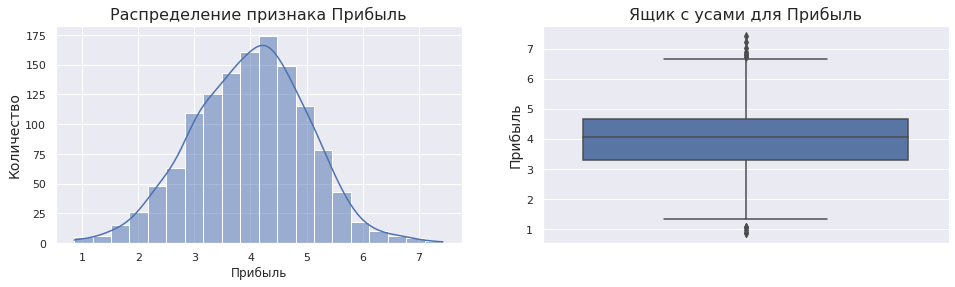

In [32]:
plot_histogram_with_boxplot(df_money, 'Прибыль')

Столбец "Прибыль" нормально распределён, имеет небольшие выбросы до значения ~1.5 и после значений ~6.7

### Вывод по разделу исследовательский анализ данных
1. **df_market_filed – Данные о маркетинговой активности**

**Этот набор данных содержит информацию о том, как пользователи взаимодействуют с маркетплейсом.**

- **Маркет_актив_6_мес** – В среднем пользователи ведут себя стабильно, но есть небольшая группа с крайне низкими значениями. Возможно, это пассивные клиенты или технические ошибки.
- **Маркет_актив_тек_мес** – Можно разделить пользователей на несколько категорий по уровню активности за последний месяц.
- **Длительность** – Пользователи проводят в системе разное количество времени, но разброс значений не критичный.
- **Акционные_покупки** – Есть два ярко выраженных типа пользователей: одни покупают почти исключительно по акциям, другие практически не используют скидки. Стоит изучить их поведение отдельно.
- **Средний_просмотр_категорий_за_визит** – Достаточно равномерное распределение, можно сгруппировать в несколько уровней.
- **Неоплаченные_продукты_штук_квартал** – Большинство пользователей оставляют в корзине до 8 товаров, но есть редкие случаи с большим количеством.
- **Ошибка_сервиса** – Значения распределены равномерно, можно разделить пользователей на группы по количеству столкнувшихся с проблемами.
- **Страниц_за_визит** – Чем больше страниц смотрит пользователь, тем активнее он себя ведет. Большинство пользователей укладываются в диапазон до 20 страниц.

2. **df_market_money – Данные о выручке**

**Содержит информацию о сумме выручки с пользователей. Были удалены аномальные значения (0 и >10000), так как они не представляют ценности для анализа.**

- **id** – Уникальный идентификатор пользователя.
- **Выручка** – В среднем пользователи тратят около 5000, но встречаются нулевые значения – это те, кто ничего не купил. Также были очень большие значения, которые пришлось удалить как выбросы.

3. **df_market_time** – Данные о времени взаимодействия

Содержит информацию о том, сколько времени пользователи проводят в сервисе.

- **id** – Уникальный идентификатор пользователя.
- **минут** – Время распределено достаточно равномерно, большинство пользователей проводят на сайте от 4 до 23 минут.

4. **df_money* – Данные о прибыли**

**Содержит информацию о прибыли, полученной от пользователей.**

- **id** – Уникальный идентификатор пользователя.
- **Прибыль** – В среднем она составляет около 4, но есть редкие случаи с очень низкими или очень высокими значениями.

## Объединение таблиц

In [33]:
df_market_filed.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [34]:
df_market_money.head()

,id,Период,Выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0


In [35]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [36]:
df_market_money_join = df_market_money.pivot_table(index=['id'], columns=['Период'])
df_market_money_join.columns = ["Выручка_предыдущий_месяц", "Выручка_препредыдущий_месяц", "Выручка_текущий_месяц"]
df_market_money_join.head()

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [37]:
df_market_time_join = df_market_time.pivot_table(index=['id'], columns=['Период'])
df_market_time_join.columns = ["Минут_предыдущий_месяц", "Минут_текущий_месяц"]
df_market_time_join.head()

,Минут_предыдущий_месяц,Минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [38]:
#Объединяем таблицы с помощью join()
df_final = df_market_filed.join(df_market_money_join, on='id', how="left")

df_final = df_final.join(df_market_time_join, on='id', how="left")
# Выводим результат
df_final.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [39]:
df_final.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               3
Выручка_препредыдущий_месяц            3
Выручка_текущий_месяц                  1
Минут_предыдущий_месяц                 0
Минут_текущий_месяц                    0
dtype: int64

In [40]:
# Удаляем пропуски
df_final = df_final.dropna()
df_final.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
Минут_предыдущий_месяц                 0
Минут_текущий_месяц                    0
dtype: int64

In [41]:
# Проверка на дубликаты
df_final.duplicated().sum()

0

Дубликатов не выявлено

In [42]:
# Теперь получаем статистику по всем числовым столбцам
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1296.0,215999.464506,374.327860,215349.00,215675.750,215999.50,216323.250,216647.00
Маркет_актив_6_мес,1296.0,4.256404,1.013525,0.90,3.700,4.20,4.900,6.60
Длительность,1296.0,602.967593,249.195823,121.00,409.500,606.50,806.250,1079.00
Акционные_покупки,1296.0,0.320069,0.249159,0.11,0.170,0.24,0.300,0.99
Страниц_за_визит,1296.0,8.187500,3.978459,1.00,5.000,8.00,11.000,20.00
Выручка_предыдущий_месяц,1296.0,4947.468750,700.797239,2890.00,4498.125,5005.50,5405.625,6869.50
Выручка_препредыдущий_месяц,1296.0,4836.202160,333.514091,4098.00,4584.500,4810.50,5056.000,5663.00
Выручка_текущий_месяц,1296.0,5238.096065,834.318717,2758.70,4706.050,5179.95,5759.275,7799.40
Минут_предыдущий_месяц,1296.0,13.470679,3.937630,5.00,10.750,13.00,17.000,23.00
Минут_текущий_месяц,1296.0,13.210648,4.221794,4.00,10.000,13.00,16.000,23.00


### Вывод 
- Слиятние таблиц выполнено успешно
- 4 пропуска было удалено
- Дубликатов не обнаружено
- Количество строк сократилось с 1300 до 1296

## Корреляционный анализ

In [43]:
df_final.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


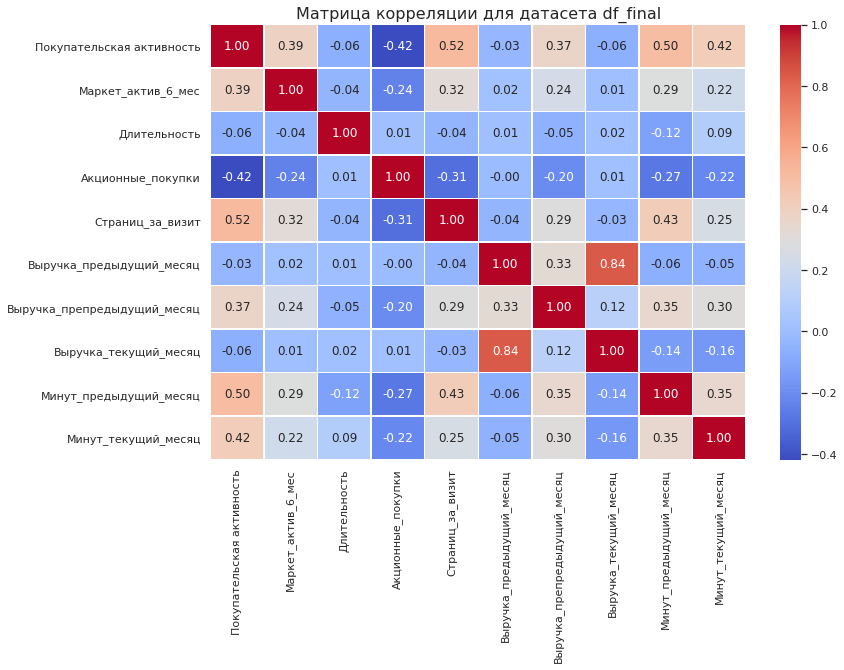

In [44]:
df_final_copy = df_final.copy()
df_final_copy = df_final_copy.drop('id', axis=1)
df_final_copy['Покупательская активность'] = df_final_copy['Покупательская активность'].replace('Снизилась', '0')
df_final_copy['Покупательская активность'] = df_final_copy['Покупательская активность'].replace('Прежний уровень', '1').astype('int')

# Рассчитываем матрицу корреляции для количественных значений
corr_matrix = df_final_copy.corr()

# Настройка графика
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

# Заголовок
plt.title("Матрица корреляции для датасета df_final", fontsize=16)

# Показать график
plt.show()


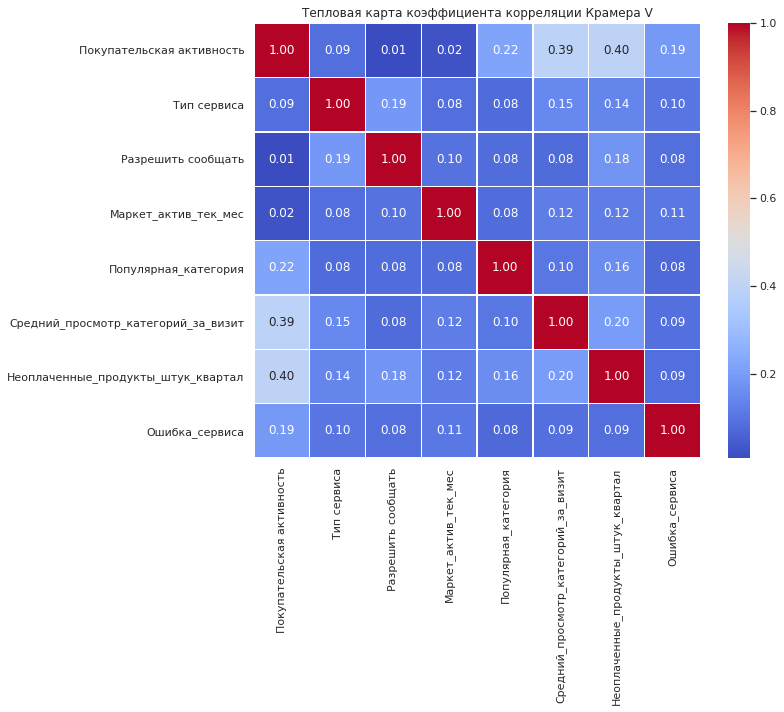

In [45]:
# Преобразуем категориальные столбцы в тип категориальных данных
categorical_columns = df_final.select_dtypes(include=['object', 'category']).columns

# Функция для расчета коэффициента Крамера V
def cramers_v(crosstab):
    chi2, p, dof, expected = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    return np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))

# Создадим таблицу корреляций Крамера V для всех категориальных признаков
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            crosstab = pd.crosstab(df_final[col1], df_final[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(crosstab)
        else:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Полная зависимость с собой

# Преобразуем значения в float для удобного отображения
cramers_v_matrix = cramers_v_matrix.astype(float)

# Построим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Тепловая карта коэффициента корреляции Крамера V')
plt.show()


In [46]:
# Выбираем только числовые столбцы
numeric_cols = [
    "Маркет_актив_6_мес", "Маркет_актив_тек_мес", "Длительность", 
    "Акционные_покупки", "Средний_просмотр_категорий_за_визит",
    "Неоплаченные_продукты_штук_квартал", "Ошибка_сервиса", 
    "Страниц_за_визит", "Выручка_предыдущий_месяц", "Выручка_препредыдущий_месяц", 
    "Выручка_текущий_месяц", "Минут_предыдущий_месяц", "Минут_текущий_месяц"
]

# Делаем DataFrame только с числовыми данными
X = df_final[numeric_cols]

X = sm.add_constant(X)

# Рассчитываем VIF для каждого столбца
vif_data = pd.DataFrame()
vif_data["Фактор"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Выводим результат
print(vif_data.sort_values(by="VIF", ascending=False))


                                 Фактор         VIF
0                                 const  352.524089
9              Выручка_предыдущий_месяц    4.263015
11                Выручка_текущий_месяц    3.896191
10          Выручка_препредыдущий_месяц    1.612075
12               Минут_предыдущий_месяц    1.526838
8                      Страниц_за_визит    1.418264
13                  Минут_текущий_месяц    1.321172
1                    Маркет_актив_6_мес    1.220849
6    Неоплаченные_продукты_штук_квартал    1.198629
4                     Акционные_покупки    1.185679
5   Средний_просмотр_категорий_за_визит    1.178602
3                          Длительность    1.099452
7                        Ошибка_сервиса    1.079350
2                  Маркет_актив_тек_мес    1.044578


### Вывод по разделу корреляционный анализ

**Было выведено 2 матрицы корреляции для количиственных и для котегоиальных значений**

1. Коэффициент корреляции Спирмена между всеми числовыми признаками

    1.1 Столбцы которые имеют корреляцию с целевым признаком:
        - Маркет_актив_6_мес, 
        - Акционные_покупки, 
        - Страниц за визит,
        - Выручка_препредыдущий_месяц, 
        - Минут_предыдущий_месяц, 
        - Минут_текущий_месяц.
    
    1.2 Столбцы которые имеют корреляцию между собой, но не с целевым признаком
        - Смльно коррелируют между собой Выручка_препредыдущий_месяц и Выручка_предыдущий_месяц
    
2. Коэффициент корреляции Крамера между всеми котегориальными признаками
    2.1 Столбцы которые имеют корреляцию с целевым признаком:
        - Средний_просмотр_категорий_за_визит, 
        - Неоплаченные_продукты_штук_квартал,

3. Мультиколениароности между признаками в основном нет, кроме признаков Выручка_препредыдущий_месяц и Выручка_предыдущий_месяц, но она тут в пределах нормы, VIF < 5.

## Использование пайплайнов

In [47]:
df_final.loc[:, 'Покупательская активность'] = df_final['Покупательская активность']\
    .apply(lambda x: 1 if x == 'Снизилась' else 0)
df_final['Покупательская активность'] = df_final['Покупательская активность'].astype(int) 

df_final.loc[:,'Акционные_покупки'] = df_final['Акционные_покупки']\
    .apply(lambda x: 'Редко' if x < 0.6 else 'Часто')

df_final = df_final.set_index('id')

df_final.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,Часто,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,Редко,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,Часто,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,Часто,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,Редко,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [48]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X = df_final.drop('Покупательская активность' , axis=1)
y = df_final['Покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [49]:
ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
ord_columns = ['Акционные_покупки']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 
               'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минут_предыдущий_месяц', 
               'Минут_текущий_месяц']

In [50]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first'))
    ]
)

In [51]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[['Редко','Часто']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [52]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [53]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [54]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 7),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=42, probability=True)],
        'models__kernel': ['poly', 'rbf'],
        'models__degree': range(2, 6),
        'models__C': np.logspace(-2, 2, 5),
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [55]:
random = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [56]:
random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип '
                                                                                'сервиса',
                                                                                'Разрешить '
                                                                                'сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                         'models__degree': range(2, 6),
                                         'models__gamma': ['scale', 'auto'],
                                         'models__kernel': ['poly', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [57]:
print('Лучшие параметры: ', random.best_estimator_)

Лучшие параметры:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord

In [58]:
print('Лучшая точность на кросс валидации: ', random.best_score_)

Лучшая точность на кросс валидации:  0.9057607509076636


In [59]:
y_test_pred = random.predict(X_test)
y_test_proba = random.predict_proba(X_test)
print('ROC-AUC: ', roc_auc_score(y_test, y_test_proba[:,1]))
print('f1: ', roc_auc_score(y_test, y_test_pred))

ROC-AUC:  0.906644080557124
f1:  0.8815170336909467


### Мини вывод по разделу использование пайплайнов
В результате подбора гиперпараметров лучшей моделью оказался SVC (Support Vector Classifier) с параметрами:
- C=0.1
- degree=2
- gamma='auto'
- kernel='poly'
- probability=True

Результаты обучения модели:
- Лучшая точность на кросс-валидации: 0.906
- ROC-AUC на тестовой выборке: 0.907
- F1-score: 0.88

Метрика ROC-AUC выбрана, потому что:

- Учитывает дисбаланс классов – Точность может вводить в заблуждение, если классы несбалансированы.
- Оценивает модель по всей шкале порогов – Не зависит от конкретного порога, в отличие от F1-score.
- Бизнес-значимость – Важно правильно выявлять клиентов с риском снижения активности, чтобы минимизировать потери.

Дополнительно оценивали F1-score, так как он учитывает баланс между точностью и полнотой. Высокое значение F1 (0.88) подтверждает, что модель не только правильно классифицирует клиентов, но и делает это без чрезмерного количества ложных срабатываний.

**Модель показывает высокую предсказательную способность, особенно по метрике ROC-AUC (0.907), что говорит о хорошем разделении классов.**

## Анализ важности признаков

In [60]:
print(X_train.shape, X_test.shape)

(1036, 16) (260, 16)


In [61]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVC(C=0.1, 
                       degree=2, 
                       gamma='auto', 
                       probability=True,
                       random_state=42))
    ]
)

In [62]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                                                                   SimpleIm...
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'Выручка_предыдущий_месяц',
                                                   'Выручка_препредыдущий_месяц',
                                                   'Выручка_текущий_месяц',
                                                   'Минут_предыдущий_месяц',
                                                   'Минут_текущий_месяц'])])),
                ('models',
                 SVC(C=0.1, degree=2, gamma='auto', probability=True,
                     random_state=42))])

In [63]:
# Получаем лучший модельный компонент из пайплайна
best_model = pipe_final.named_steps['models']
preprocessor = pipe_final.named_steps['preprocessor']
COUNT = 50

In [64]:
# Применяем преобразования к обучающим и тестовым данным
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Извлекаем OneHotEncoder из пайплайна ohe_pipe
ohe_encoder = preprocessor.named_transformers_['ohe'].named_steps['ohe']

# Проверяем доступные методы в OneHotEncoder
if hasattr(ohe_encoder, "get_feature_names_out"):
    # Для новых версий sklearn
    ohe_feature_names = ohe_encoder.get_feature_names_out(input_features=ohe_columns)
else: 
    # Для старых версий sklearn
    categories = ohe_encoder.categories_
    ohe_feature_names = [f"{col}_{val}" for col, vals in zip(ohe_columns, categories) for val in vals]

# Получаем имена других признаков
ord_feature_names = ord_columns  # Предполагается, что ord_columns заранее определены
num_feature_names = num_columns  # Предполагается, что num_columns заранее определены

# Объединяем все имена признаков
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Преобразуем в DataFrame с правильными именами
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Выбираем случайную выборку для SHAP
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=42)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=42)

# Проверяем размеры выборок
print(f"Размер X_train_preprocessed_smpl: {X_train_preprocessed_smpl.shape}")
print(f"Размер X_test_preprocessed_smpl: {X_test_preprocessed_smpl.shape}")

# Создаем SHAP explainer для модели SVC
explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed)

# Вычисляем значения SHAP для выборки
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

Using 1036 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Размер X_train_preprocessed_smpl: (50, 20)
Размер X_test_preprocessed_smpl: (50, 20)


  0%|          | 0/50 [00:00<?, ?it/s]

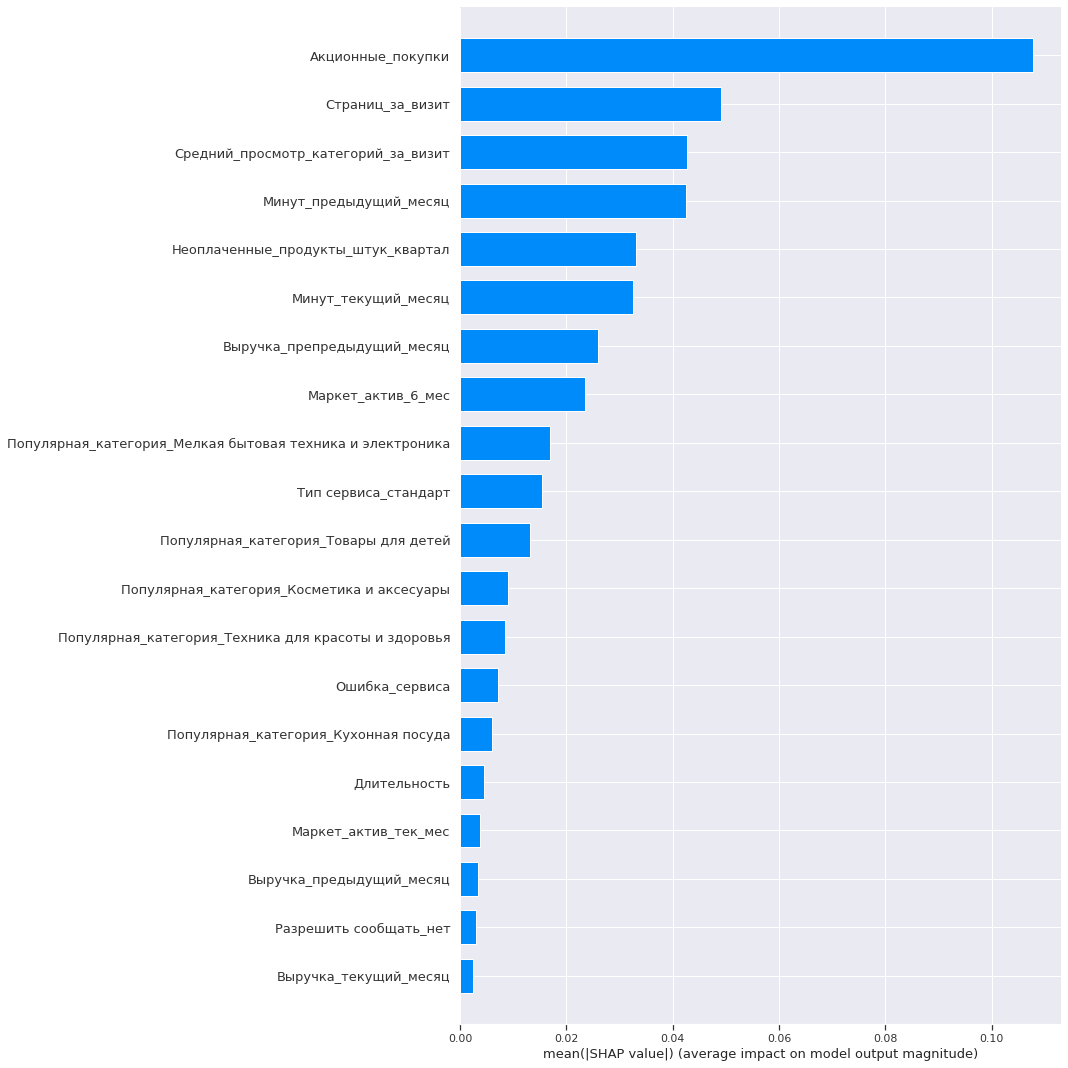

In [65]:
shap.summary_plot(
    shap_values, 
    X_test_preprocessed_smpl, 
    plot_type="bar", 
    max_display=30, 
    plot_size=(15, 15)
)
plt.show()

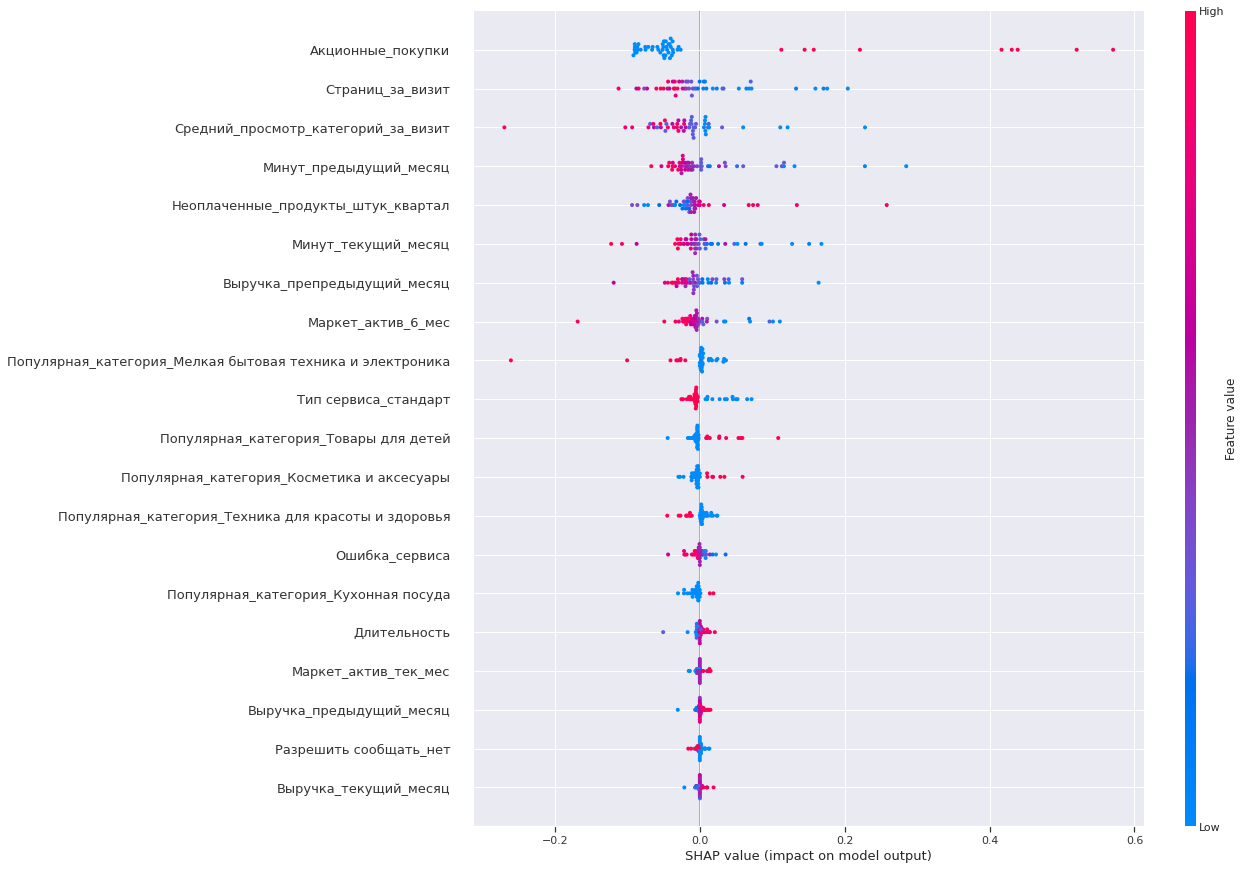

In [66]:
# Преобразуем shap_values в объект Explanation
shap_values_explained = shap.Explanation(values=shap_values, 
                                          base_values=explainer.expected_value, 
                                          data=X_test_preprocessed_smpl)

# График beeswarm
shap.plots.beeswarm(
    shap_values_explained, 
    max_display=30, 
    plot_size=(15, 15), 
    show=False
)
plt.show()


### Вывод
Для модели самым важным парамтром оказался **"Акционные покупки"**.

Так же важные параметры это:
 - Неоплаченные продукты
 - Страниц за визит
 - Средний просмотр котегорий за визит 
 - Минут предыдущий месяц
 
 Остальные параметры оказались менее важными для данной модели 
 
 

## Сегментация покупателей

In [67]:
y_test_proba = random.predict_proba(X_test)[:,1]
y_train_proba = random.predict_proba(X_train)[:,1]

X_test_final = X_test.copy()
X_train_final = X_train.copy()
X_test_final['Вероятность_снижения'] = y_test_proba
X_train_final['Вероятность_снижения'] = y_train_proba
df_segment = pd.concat([X_train_final, X_test_final])

df_money = df_money.set_index('id')
df_segment = df_segment.join(df_money)

In [68]:
df_segment.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Вероятность_снижения,Прибыль
id,,,,,,,,,,,,,,,,,,
215884,стандарт,да,4.3,5,997,Редко,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,0.175369,4.37
216003,премиум,да,5.5,5,913,Редко,Кухонная посуда,3,1,7,10,3903.0,4833.0,3227.0,17,23,0.116694,4.87
215685,стандарт,нет,4.4,5,517,Редко,Товары для детей,1,2,5,11,3130.0,4382.0,4345.5,11,12,0.605389,4.33
216442,стандарт,да,3.8,4,907,Редко,Косметика и аксесуары,2,1,8,4,3829.0,4837.0,3085.4,13,20,0.345486,5.10
215718,стандарт,нет,3.1,5,447,Редко,Домашний текстиль,2,4,6,4,5562.5,4217.0,6220.3,8,9,0.985903,4.84


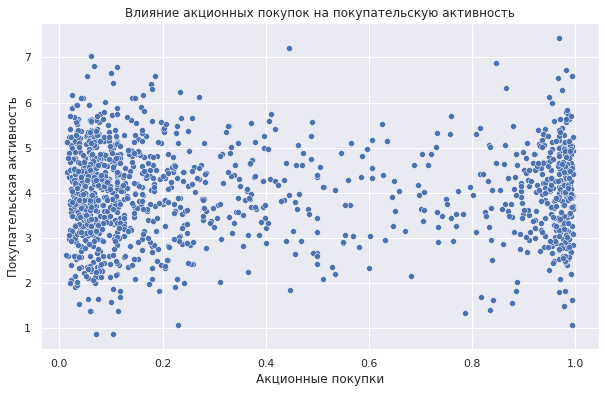

In [69]:
# График зависимости покупательской активности от "Акционных покупок"
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Вероятность_снижения', y='Прибыль', data=df_segment)
plt.title('Влияние акционных покупок на покупательскую активность')
plt.xlabel('Акционные покупки')
plt.ylabel('Покупательская активность')
plt.show()


Явной зависимости не выявлено

In [70]:
def scatterplot_and_proba(column):
    plt.figure(figsize=(15, 15))
    sns.scatterplot(x='Вероятность_снижения', y='Прибыль', data=df_segment, hue=column)
    plt.title(f'Влияние {column} на вероятность снижения активности и прибыли')
    plt.xlabel('Вероятность снижения')
    plt.ylabel('Прибыль')
    plt.show()

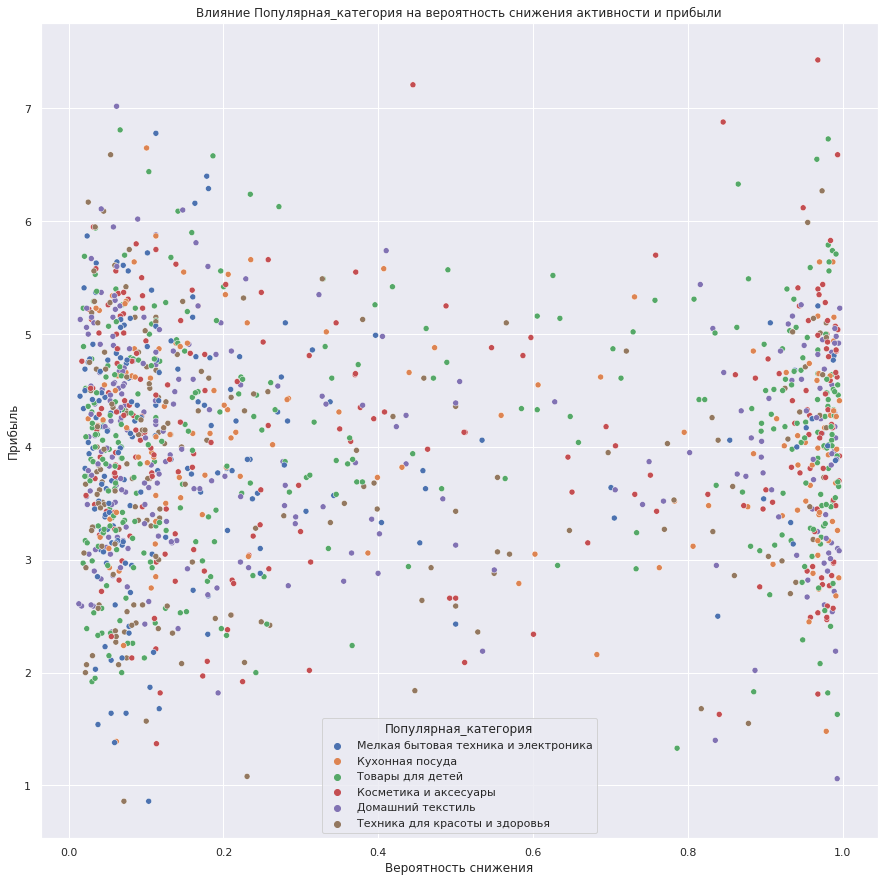

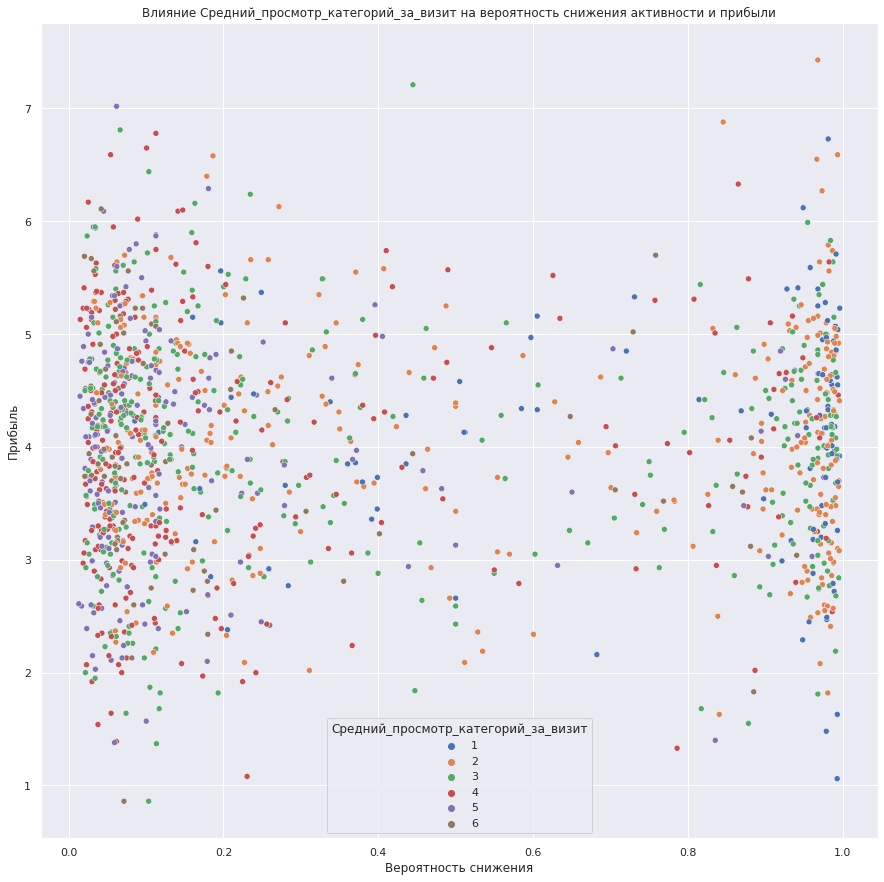

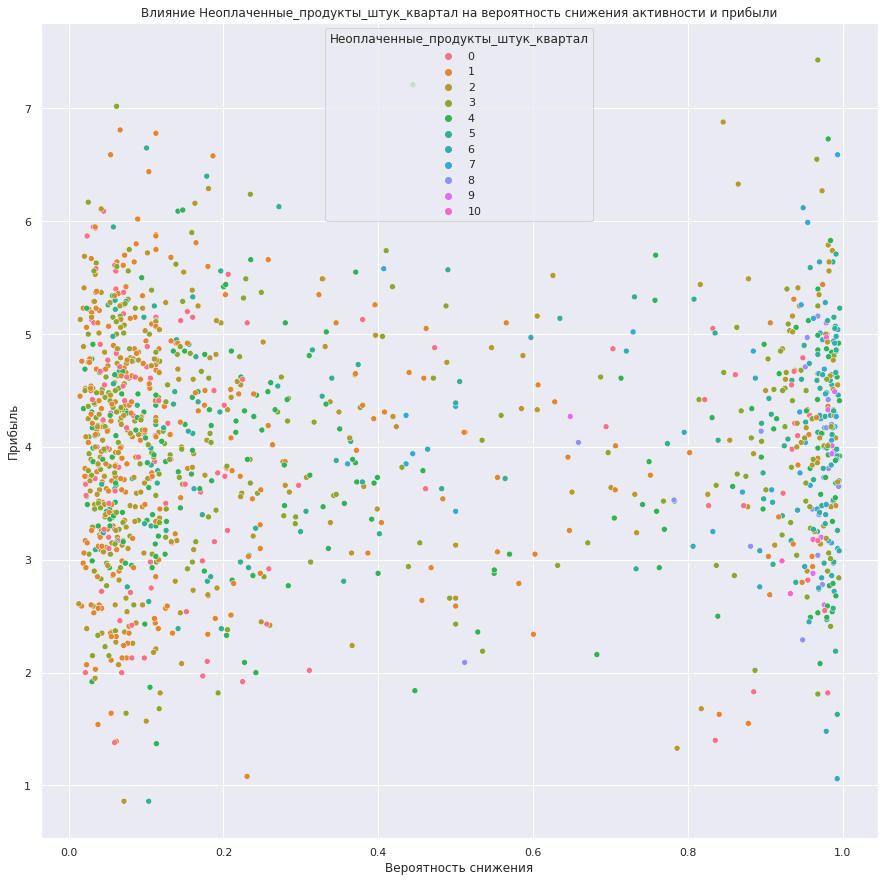

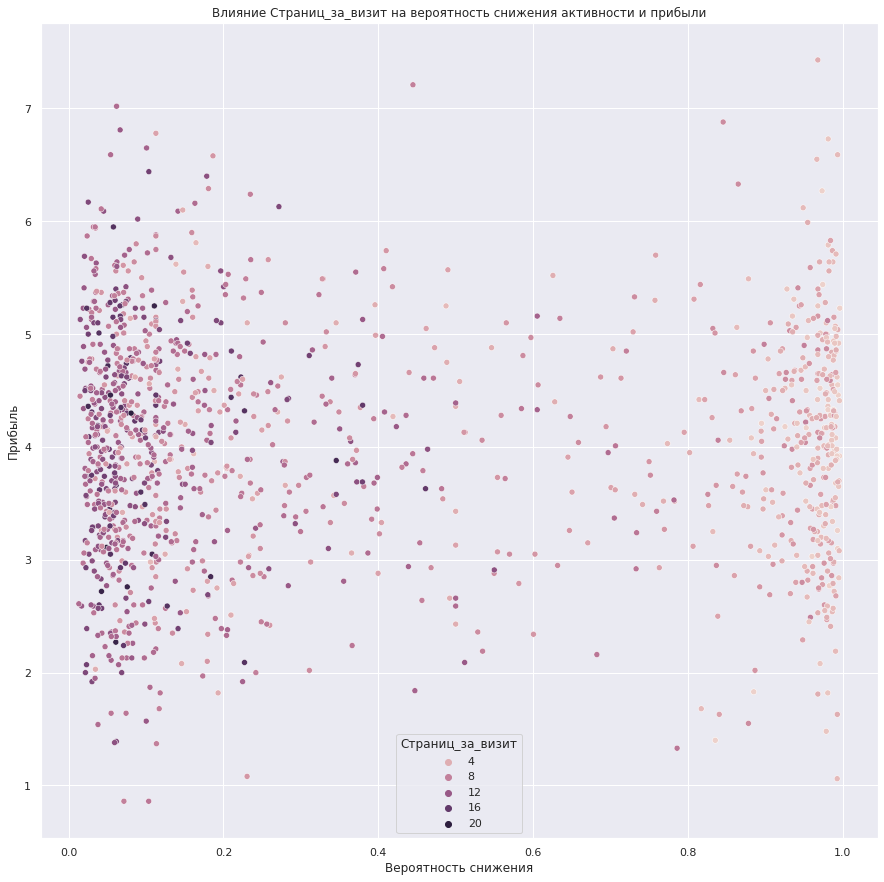

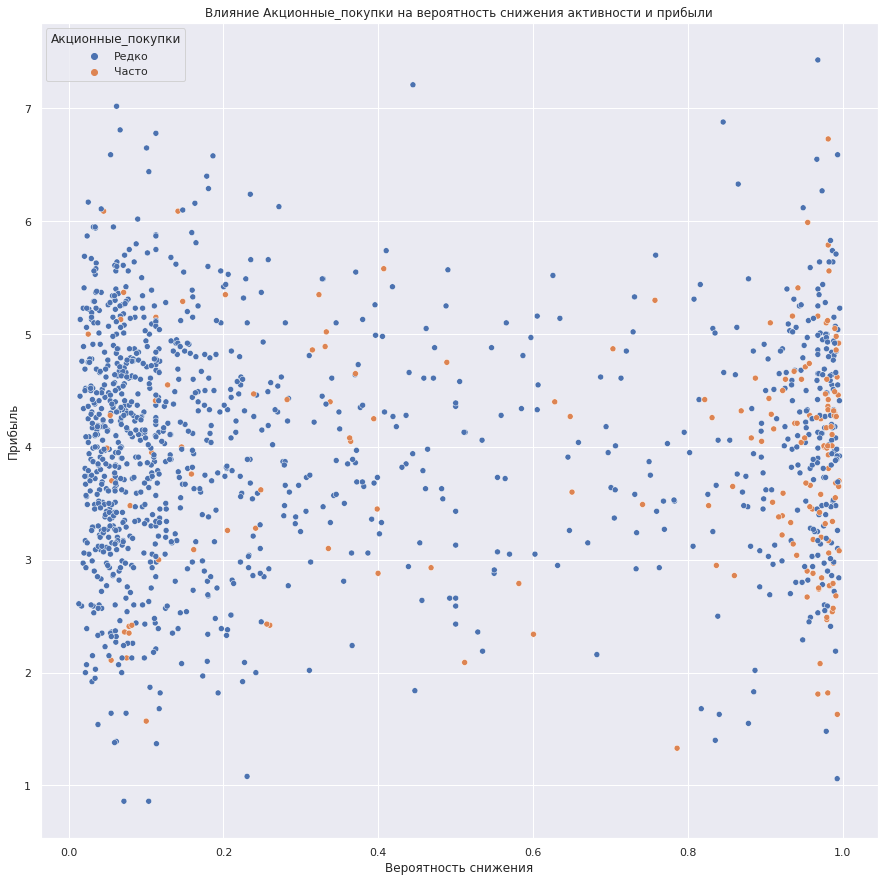

In [71]:
columns = ['Популярная_категория', 'Средний_просмотр_категорий_за_визит',
          'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит', 'Акционные_покупки']

for column in columns:
    scatterplot_and_proba(column)

На графике который отражает "Неоплаченные продукты" на вероятность можно заметить, что чем больше неоплаченных продуктов на пользователя,тем больше шанс того что покупательская активность данного пользователя снизится, но тут сложно сказать точно, потому, что бывает такое, что у пользователя покупательская активность растёт и количество неоплаченных продуктов тоже растёт.

На графике который отражает "Страниц за визит" на вероятность можно заметить, что чем меньше страниц просматривает пользователь тем больше вероятность того, что покупательская активность данного пользователя снизится.

На графике который отражает "Акционные покупки" на вероятность можно заметить, что пользователи которые часто покупают по акции имеют высокую вероятность снижения активности покупок.

Явного влияния параметров 'Популярная_категория', 'Средний_просмотр_категорий_за_визит' выявлено не было

In [72]:
# Выберем пользователей у которых больше всего вероятность снижения активности 
df_segment['Вероятность_снижения_сегмент'] = df_segment.apply( lambda row: 'Высокая вероятность' \
        if row['Вероятность_снижения'] > 0.8 and row['Акционные_покупки']=='Часто' \
        else 'Другая вероятность', axis=1)

df_segment.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Вероятность_снижения,Прибыль,Вероятность_снижения_сегмент
id,,,,,,,,,,,,,,,,,,,
215884,стандарт,да,4.3,5,997,Редко,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,0.175369,4.37,Другая вероятность
216003,премиум,да,5.5,5,913,Редко,Кухонная посуда,3,1,7,10,3903.0,4833.0,3227.0,17,23,0.116694,4.87,Другая вероятность
215685,стандарт,нет,4.4,5,517,Редко,Товары для детей,1,2,5,11,3130.0,4382.0,4345.5,11,12,0.605389,4.33,Другая вероятность
216442,стандарт,да,3.8,4,907,Редко,Косметика и аксесуары,2,1,8,4,3829.0,4837.0,3085.4,13,20,0.345486,5.10,Другая вероятность
215718,стандарт,нет,3.1,5,447,Редко,Домашний текстиль,2,4,6,4,5562.5,4217.0,6220.3,8,9,0.985903,4.84,Другая вероятность


In [73]:
df_segment['Вероятность_снижения_сегмент'].count()

1296

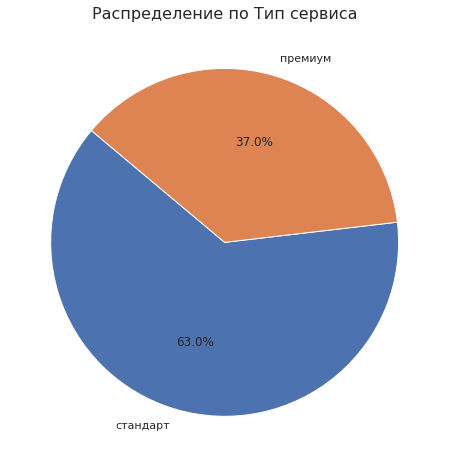

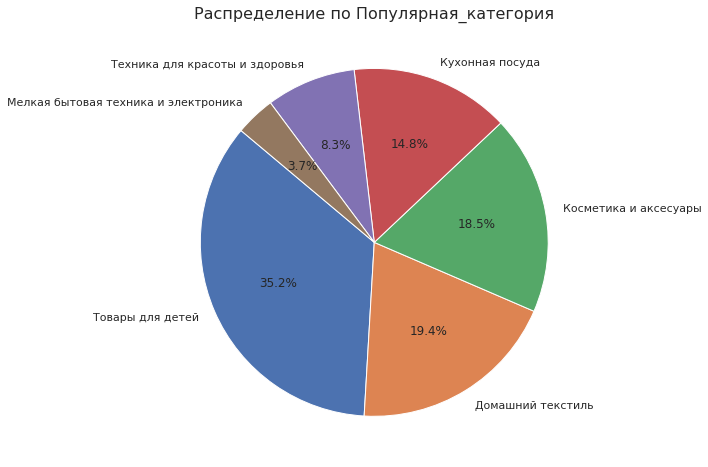

In [74]:
col_pie = ['Тип сервиса', 'Популярная_категория']

for columns in col_pie:
    plot_pivot_pie_chart(df_segment[df_segment['Вероятность_снижения_сегмент'] == 'Высокая вероятность'], columns)

Пользователи, которые имеют высокую вероятность снижения активности реже покупают подписку, что, вероятно, может объясняться тем фактом, что данная категория пользователей пытается сэкономить как можно больше денг. Так же данные пользователи скорее всего имеют детей, что добавляет какие то ограничения при покупках, и экономии средств

In [75]:
col = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса']
for i in col:
    df_segment[i] = df_segment[i].astype(int) 

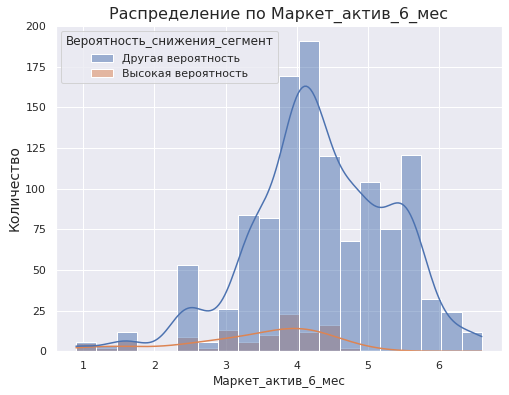

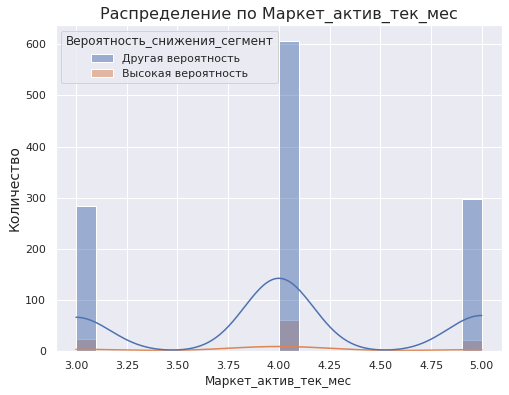

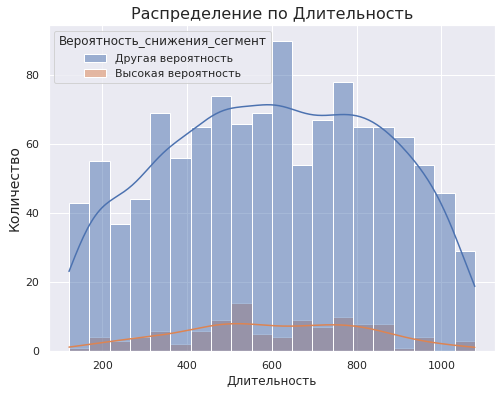

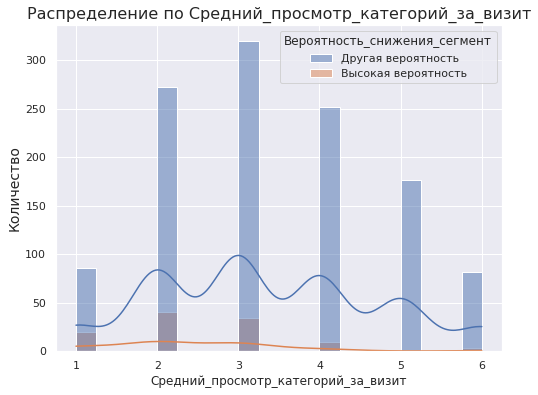

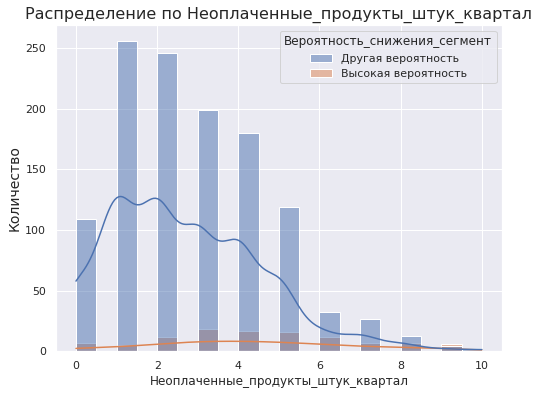

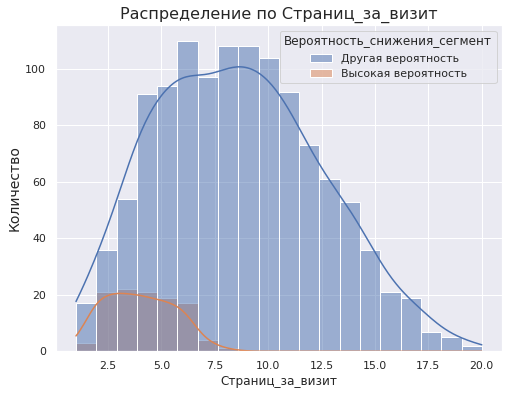

In [76]:
col_raspr = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 
             'Неоплаченные_продукты_штук_квартал', 'Страниц_за_визит']
for column in col_raspr:
    plot_histogram(df_segment, column, 'Вероятность_снижения_сегмент')

Пользователи, которые имеют высокую вероятнсть снижения активности просматривают меньше котегорий за визит, что может говорить о том, что данная категория пользователей выбирают какой то конкретный товар или котегорию

Пользователи, которые имеют высокую вероятнсть снижения активности, имеют больше неоплаченных товаров за квартал 

Активность пользователей с высокой вероятностью снижения активности сопостовляется с основной группой пользователей

In [77]:
# Создаем сводную таблицу с суммарной выручкой по категориям товаров
pivot_table = df_segment.pivot_table(
    values=['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц'],
    index=['Популярная_категория', 'Акционные_покупки'],
    aggfunc='sum'
).reset_index()

pivot_table

,Популярная_категория,Акционные_покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,Домашний текстиль,Редко,1133917.0,1080391.0,1191889.2
1,Домашний текстиль,Часто,139918.5,131374.0,149420.2
2,Косметика и аксесуары,Редко,980595.5,934740.0,1032039.1
3,Косметика и аксесуары,Часто,156755.5,140715.0,166995.6
4,Кухонная посуда,Редко,599988.5,561809.0,640083.1
5,Кухонная посуда,Часто,118534.5,103442.0,126729.7
6,Мелкая бытовая техника и электроника,Редко,801064.5,780461.0,841584.2
7,Мелкая бытовая техника и электроника,Часто,73856.5,69556.0,78435.1
8,Техника для красоты и здоровья,Редко,740000.0,765575.0,789501.5
9,Техника для красоты и здоровья,Часто,108275.0,114875.0,117731.2


In [78]:
# Разделяем данные на акционные и обычные покупки
df_promo = pivot_table[pivot_table['Акционные_покупки'] == 'Часто']  # Товары, которые продаются по акциям
df_non_promo = pivot_table[pivot_table['Акционные_покупки'] == 'Редко']  # Обычные покупки

In [79]:
df_promo

,Популярная_категория,Акционные_покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
1,Домашний текстиль,Часто,139918.5,131374.0,149420.2
3,Косметика и аксесуары,Часто,156755.5,140715.0,166995.6
5,Кухонная посуда,Часто,118534.5,103442.0,126729.7
7,Мелкая бытовая техника и электроника,Часто,73856.5,69556.0,78435.1
9,Техника для красоты и здоровья,Часто,108275.0,114875.0,117731.2
11,Товары для детей,Часто,226595.0,226683.0,237245.9


In [80]:
df_non_promo

,Популярная_категория,Акционные_покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,Домашний текстиль,Редко,1133917.0,1080391.0,1191889.2
2,Косметика и аксесуары,Редко,980595.5,934740.0,1032039.1
4,Кухонная посуда,Редко,599988.5,561809.0,640083.1
6,Мелкая бытовая техника и электроника,Редко,801064.5,780461.0,841584.2
8,Техника для красоты и здоровья,Редко,740000.0,765575.0,789501.5
10,Товары для детей,Редко,1332419.0,1358097.0,1416917.7


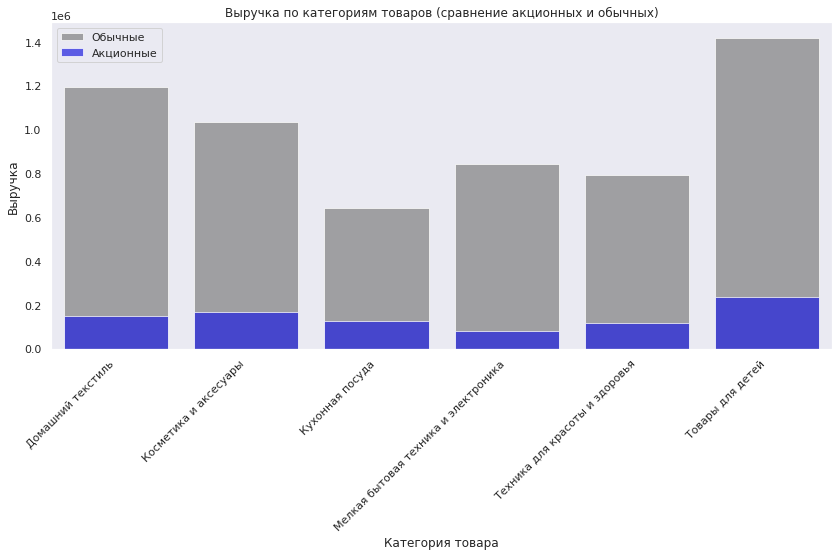

In [81]:
# Визуализация: сравнение выручки по категориям с учетом акций
plt.figure(figsize=(14, 6))
sns.barplot(data=df_non_promo, x='Популярная_категория', y='Выручка_текущий_месяц', color='gray', label='Обычные', alpha=0.7)
sns.barplot(data=df_promo, x='Популярная_категория', y='Выручка_текущий_месяц', color='blue', label='Акционные', alpha=0.7)
plt.title("Выручка по категориям товаров (сравнение акционных и обычных)")
plt.ylabel("Выручка")
plt.xlabel("Категория товара")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

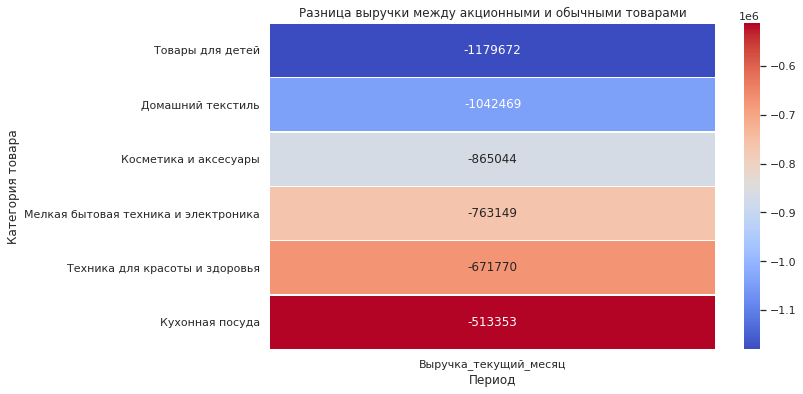

In [82]:
# Тепловая карта разницы между акционными и обычными покупками
pivot_diff = df_promo.set_index('Популярная_категория')[['Выручка_текущий_месяц']] - \
             df_non_promo.set_index('Популярная_категория')[['Выручка_текущий_месяц']]

pivot_diff = pivot_diff.sort_values(by='Выручка_текущий_месяц', ascending=True)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_diff, annot=True, fmt=".0f", cmap='coolwarm', linewidths=0.5)
plt.title("Разница выручки между акционными и обычными товарами")
plt.ylabel("Категория товара")
plt.xlabel("Период")
plt.show()

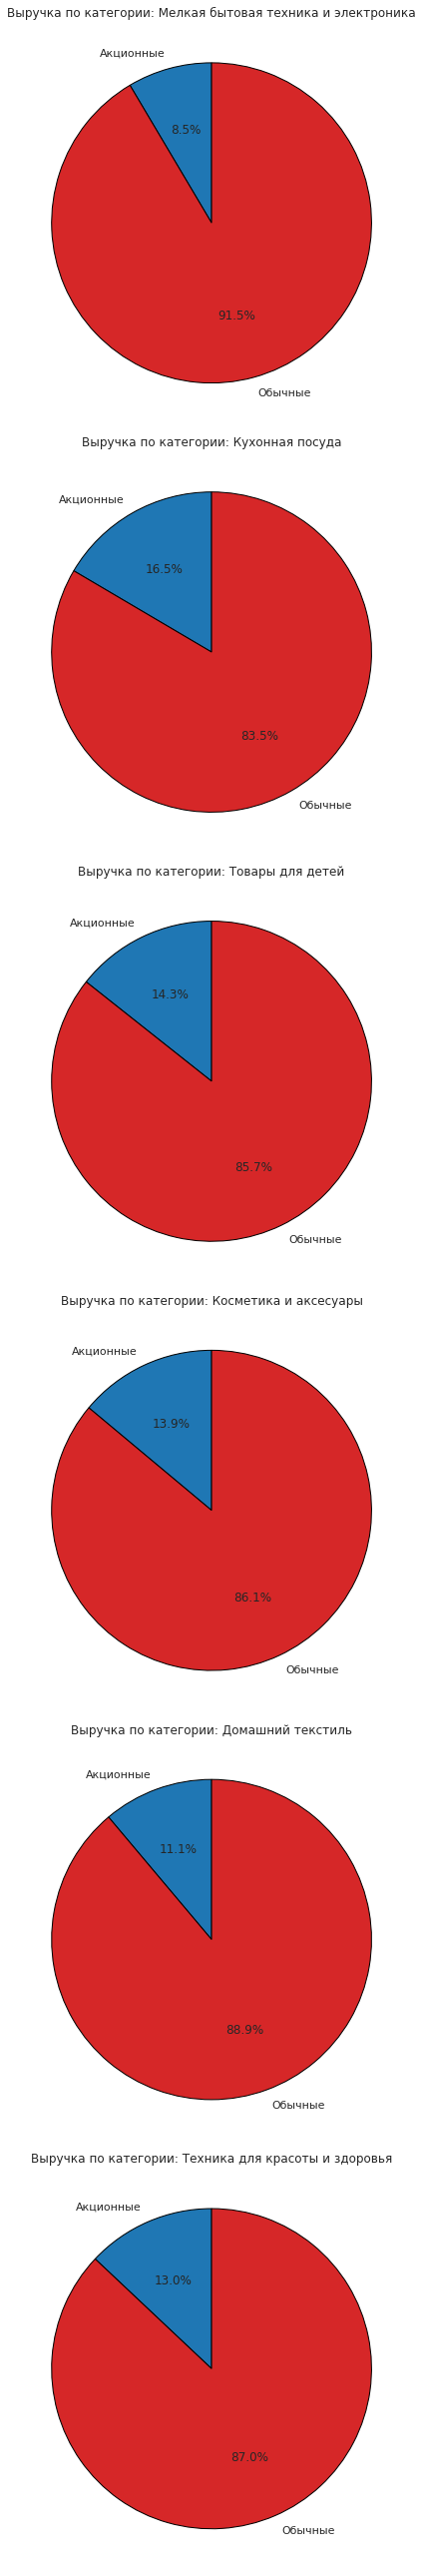

In [83]:
# Визуализация: сравнение выручки по категориям с учетом акций (отдельные графики)
categories = df_segment['Популярная_категория'].unique()

fig, axes = plt.subplots(nrows=len(categories), figsize=(12, len(categories) * 6), sharex=True)

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Выбираем данные для акций и без
    data_cat_promo = df_promo[df_promo['Популярная_категория'] == category]
    data_cat_non_promo = df_non_promo[df_non_promo['Популярная_категория'] == category]
    
    # Вычисляем суммарную выручку по категориям
    promo_revenue = data_cat_promo['Выручка_текущий_месяц'].sum()
    non_promo_revenue = data_cat_non_promo['Выручка_текущий_месяц'].sum()
    
    # Составляем список данных для круговой диаграммы
    revenue_data = [promo_revenue, non_promo_revenue]
    labels = ['Акционные', 'Обычные']
    colors = ['#1f77b4', '#d62728']  # Синий для акций, красный для обычных товаров
    
    # Строим круговую диаграмму
    ax.pie(revenue_data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f"Выручка по категории: {category}")

plt.tight_layout()
plt.show()



Без акций больше всего "Проседают" котегории товаров:
- Товары для детей
- Кухонная посуда

## Общий вывод
**1. Описание задачи**

Интернет-магазин «В один клик» заметил снижение активности покупателей. Привлекать новых клиентов становится сложнее, поэтому компания решила сосредоточиться на удержании постоянных клиентов с помощью персонализированных предложений. Для этого необходимо разработать модель, предсказывающую вероятность снижения активности клиентов, и предложить рекомендации для повышения их вовлеченности.

**2. Исходные данные и предобработка**

Были загружены четыре датасета с информацией о покупательской активности, выручке, времени на сервисе и прибыли клиентов. В ходе предобработки данных:
- Проведена проверка типов данных, пропусков и дубликатов;
- Исправлены ошибки в названиях столбцов и текстовых значениях;
- Данные объединены в единую таблицу;
- Выполнен анализ выбросов и корреляционный анализ для отбора признаков.

**3. Поиск лучшей модели**
Для предсказания активности клиентов были протестированы различные модели машинного обучения. Использовался Pipeline для автоматической обработки данных и подбора гиперпараметров. После кросс-валидации лучшей моделью оказался SVC (Support Vector Classifier) с результатами.
- Точность на кросс-валидации: 0.906
- ROC-AUC на тестовой выборке: 0.907
- F1-score: 0.88

**Модель показала высокую предсказательную способность, особенно по метрике ROC-AUC, что свидетельствует о хорошем разделении классов.**

**4. Выводы по анализу признаков**

SHAP-анализ и другие методы оценки важности признаков показали, что ключевыми факторами, влияющими на активность покупателей, являются:
- Акционные покупки – самый важный признак, клиенты, часто совершающие покупки по акциям, реже теряют активность.
- Неоплаченные продукты – чем больше товаров остается в корзине неоплаченными, тем выше вероятность снижения активности.
- Страниц за визит – активные пользователи исследуют больше страниц за один визит.
- Средний просмотр категорий за визит – пользователи с низкой активностью изучают меньше категорий товаров.
- Минуты предыдущий месяц – пользователи, которые проводили меньше времени на сайте в прошлом месяце, с высокой вероятностью снизят активность в будущем.
- Остальные параметры оказались менее значимыми для модели.

**5. Сегментация клиентов и рекомендации**
На основе анализа данных были выделены группы пользователей с высокой вероятностью снижения активности. Эта группа характеризуется:
- Реже покупают подписку, что говорит о стремлении сэкономить.
- Чаще имеют детей, что может ограничивать их бюджет.
- Выбирают конкретные товары или категории, а не просматривают весь ассортимент.
- Оставляют больше неоплаченных товаров в корзине.

**Рекомендации для увеличения активности:**
- Персонализированные скидки и акции на товары, которые часто добавляются в корзину, но не оплачиваются.
- Продвижение подписки с дополнительными бонусами, ориентированными на семьи и экономных пользователей.
- Мотивационные программы (например, бонусные баллы за просмотры категорий или количество заказов).
- E-mail и push-уведомления с напоминаниями о неоплаченных товарах.

**6. Итог**

**В ходе исследования была разработана модель, предсказывающая вероятность снижения активности клиентов. На основе анализа ключевых факторов предложены маркетинговые стратегии для повышения вовлеченности пользователей и увеличения прибыли компании. Эти меры позволят удержать клиентов и снизить потери из-за падения покупательской активности.**